In [39]:
# Importar librería para cargar datos procesados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Importar modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Importar funciones para el entrenamiento y validación de los modelos
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,  roc_curve, auc
from sklearn.model_selection import learning_curve

#Importa MLFLOW
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature



## Carga de datos

In [35]:
# Datos de entrenamiento
X_train = pd.read_parquet('../../data/processed/X_train.parquet')
y_train = pd.read_parquet('../../data/processed/y_train.parquet')

# Datos de prueba
X_test = pd.read_parquet('../../data/processed/X_test.parquet')
y_test= pd.read_parquet('../../data/processed/y_test.parquet')

In [36]:
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test: ',X_test.shape)
print('y_test: ',y_test.shape)

X_train: (940754, 44)
y_train: (940754, 1)
X_test:  (235189, 44)
y_test:  (235189, 1)


## MLFLOW

In [37]:
track_uri = "http://localhost:8080/" # Esto puede ser que cambie por http://0.0.0.0:1234
mlflow.set_tracking_uri(track_uri)
mlflow.set_registry_uri("sqlite:////tmp/registry.db")

In [38]:
# Generando el experimento o cargandolo si existe
experiment_name = "ML_COVID19-MEXICO"
mlflow.set_experiment(experiment_name)

# Cargando la información
client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

# Validacion
print(f"MLflow Version: {mlflow.__version__}")
print(f"Tracking URI: {mlflow.tracking.get_tracking_uri()}")
print(f"Nombre del experimento: {experiment_name}")
print(f"ID del experimento: {experiment_id}")

MLflow Version: 2.13.0
Tracking URI: http://localhost:8080/
Nombre del experimento: ML_COVID19-MEXICO
ID del experimento: 707578369122819239


## Regresion Logistica

c:\Users\vesna\miniconda3\envs\covid\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\vesna\miniconda3\envs\covid\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9903822032493016
Confusion Matrix:
 [[    25   2235]
 [    27 232902]]
Classification Report:
               precision    recall  f1-score   support

           1       0.48      0.01      0.02      2260
           2       0.99      1.00      1.00    232929

    accuracy                           0.99    235189
   macro avg       0.74      0.51      0.51    235189
weighted avg       0.99      0.99      0.99    235189



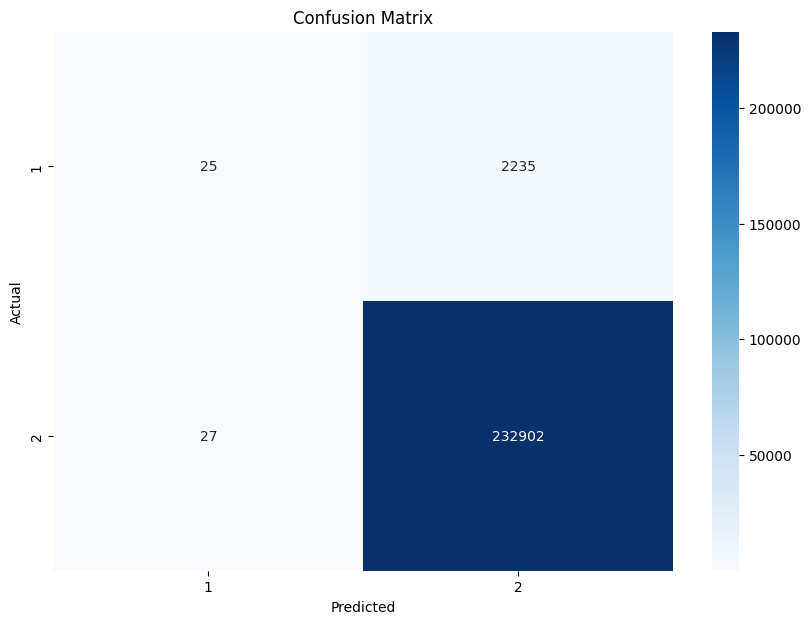

In [23]:
# Inicia una nueva ejecución en MLflow
with mlflow.start_run(run_name="Logistic Regression_20240523_1000ep"):
    # Inicializa el modelo de Regresión Logística con los hiperparámetros
    log_regression = LogisticRegression(max_iter=1000)

    # Entrena el modelo en los datos de entrenamiento
    log_regression.fit(X_train, y_train)

    # Realiza predicciones en el conjunto de prueba
    y_pred = log_regression.predict(X_test)

    # Evalúa el rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Imprime las métricas de evaluación
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_rep)

    # Registra los hiperparámetros en MLflow
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("solver", "lbfgs")
    mlflow.log_param("multi_class", "auto")
    mlflow.log_param("random_state", 8888)

    # Registra las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Guarda el modelo en MLflow
    mlflow.sklearn.log_model(log_regression, "logistic_regression_model")

    # Guarda la matriz de confusión como un artefacto

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Guarda la figura
    plt.savefig("confusion_matrix.png")

    # Registra la figura en MLflow
    mlflow.log_artifact("confusion_matrix.png")

# Finaliza la ejecución
mlflow.end_run()


c:\Users\vesna\miniconda3\envs\covid\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\vesna\miniconda3\envs\covid\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/05/26 19:36:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\vesna\AppData\Local\Temp\tmp1qeha_ng\model\model.pkl, fl

Accuracy: 0.9903822032493016
Confusion Matrix:
 [[    25   2235]
 [    27 232902]]
Classification Report:
               precision    recall  f1-score   support

           1       0.48      0.01      0.02      2260
           2       0.99      1.00      1.00    232929

    accuracy                           0.99    235189
   macro avg       0.74      0.51      0.51    235189
weighted avg       0.99      0.99      0.99    235189



FileNotFoundError: [WinError 2] The system cannot find the file specified

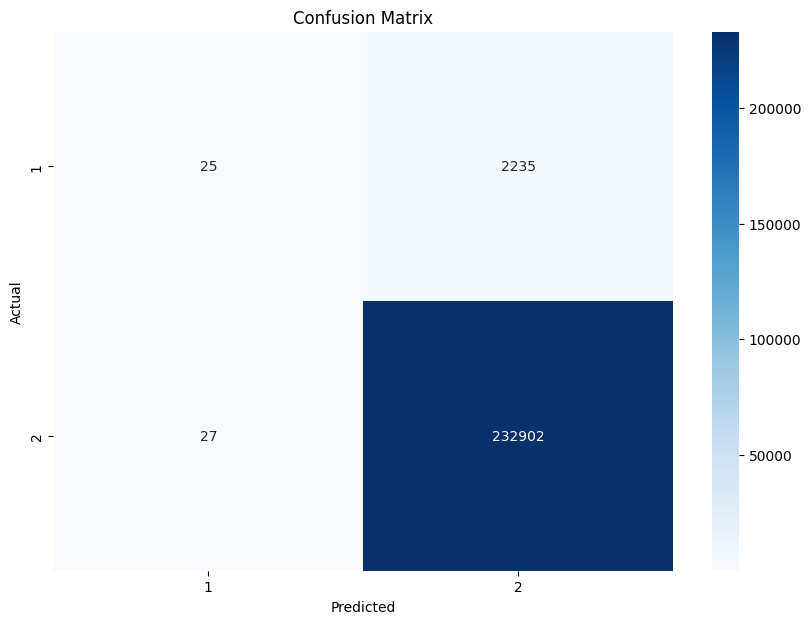

In [41]:
# Inicia una nueva ejecución en MLflow
name = "Logistic Regression_20240523_1000ep_v3"
with mlflow.start_run(run_name=name):
    # Inicializa el modelo de Regresión Logística con los hiperparámetros
    log_regression = LogisticRegression(max_iter=1000)

    # Entrena el modelo en los datos de entrenamiento
    log_regression.fit(X_train, y_train)

    # Realiza predicciones en el conjunto de prueba
    y_pred = log_regression.predict(X_test)

    # Obtiene las probabilidades predichas para la curva ROC
    y_pred_proba = log_regression.predict_proba(X_test)[:, 1]

    # Evalúa el rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Imprime las métricas de evaluación
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_rep)

    # Registra los hiperparámetros en MLflow
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("solver", "lbfgs")
    mlflow.log_param("multi_class", "auto")
    mlflow.log_param("random_state", 8888)

    # Registra las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Guarda el modelo en MLflow
    mlflow.sklearn.log_model(log_regression, "logistic_regression_model")

    # Guarda la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix_"+name+".png")
    mlflow.log_artifact("confusion_matrix_"+name+".png")

    # Genera los datos para la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(log_regression, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    # Calcula los promedios y desviaciones estándar de los puntajes de entrenamiento y prueba
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Grafica la curva de aprendizaje
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()

    # Guarda la figura de la curva de aprendizaje
    plt.savefig("learning_curve_"+name+".png")
    mlflow.log_artifact("learning_curve_"+name+".png")


    # Calcular la curva ROC y el AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plotea la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()

    # Guarda la figura de la curva ROC
    plt.savefig("roc_curve_"+name+".png")
    mlflow.log_artifact("roc_curve_"+name+".png")
    
# Finaliza la ejecución
mlflow.end_run()

## Decision Tree

Accuracy del árbol de decisión: 0.9904162184455906
Matriz de confusión del árbol de decisión:
 [[   137   2123]
 [   131 232798]]
Informe de clasificación del árbol de decisión:
               precision    recall  f1-score   support

           1       0.51      0.06      0.11      2260
           2       0.99      1.00      1.00    232929

    accuracy                           0.99    235189
   macro avg       0.75      0.53      0.55    235189
weighted avg       0.99      0.99      0.99    235189



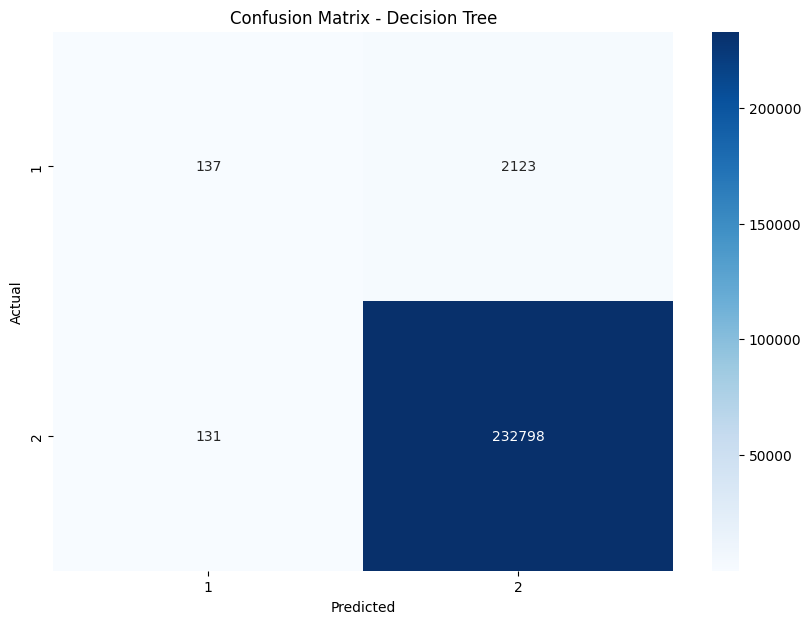

In [24]:
# Iniciar una nueva ejecución en MLflow con un nombre específico
with mlflow.start_run(run_name="Decision Tree_20240523"):
    # Inicializar el modelo de Árbol de Decisión con los hiperparámetros
    decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=100, min_samples_leaf=1000)

    # Entrenar el modelo en los datos de entrenamiento
    decision_tree.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = decision_tree.predict(X_test)

    # Evaluar el rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Imprimir las métricas de evaluación
    print("Accuracy del árbol de decisión:", accuracy)
    print("Matriz de confusión del árbol de decisión:\n", conf_matrix)
    print("Informe de clasificación del árbol de decisión:\n", classification_rep)

    # Registrar los parámetros en MLflow
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_split", 100)
    mlflow.log_param("min_samples_leaf", 1000)

    # Registrar las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(decision_tree, "decision_tree_model")

    # Opcional: Guardar la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Decision Tree")

    # Guardar la figura
    # plt.savefig("confusion_matrix_tree.png")

    # Registrar la figura en MLflow
    mlflow.log_artifact("confusion_matrix_tree.png")

# Finalizar la ejecución
mlflow.end_run()

### Ajuste de hiperparametros

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Accuracy del mejor modelo de árbol de decisión: 0.9906203096233243
Confusion Matrix del mejor modelo:
 [[   347   1913]
 [   293 232636]]
Classification Report del mejor modelo:
               precision    recall  f1-score   support

           1       0.54      0.15      0.24      2260
           2       0.99      1.00      1.00    232929

    accuracy                           0.99    235189
   macro avg       0.77      0.58      0.62    235189
weighted avg       0.99      0.99      0.99    235189



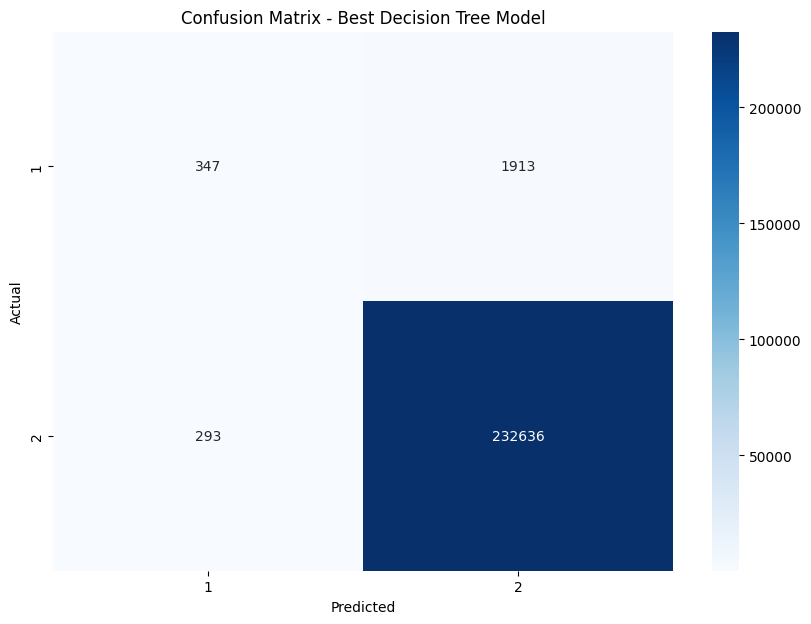

In [25]:
# Definir la cuadrícula de hiperparámetros a ajustar
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Inicializar el modelo de árbol de decisión
decision_tree = DecisionTreeClassifier()

# Inicializar GridSearchCV
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')

# Iniciar una nueva ejecución en MLflow con un nombre específico
with mlflow.start_run(run_name="Decision Tree - GridSearchCV_2023052024"):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Registrar los mejores hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_model.predict(X_test)

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_best_model)
    print("Accuracy del mejor modelo de árbol de decisión:", accuracy)

    # Registrar la métrica de precisión en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    print("Confusion Matrix del mejor modelo:\n", conf_matrix_best_model)

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model)
    print("Classification Report del mejor modelo:\n", classification_rep_best_model)

    # Guardar el mejor modelo en MLflow
    mlflow.sklearn.log_model(best_model, "best_decision_tree_model")

    # Opcional: Guardar la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Best Decision Tree Model")

    # Guardar la figura
    # plt.savefig("confusion_matrix_best_model.png")

    # Registrar la figura en MLflow
    mlflow.log_artifact("confusion_matrix_best_model.png")

# Finalizar la ejecución
mlflow.end_run()